# Análisis de Reseñas de McDonald's en North Hollywood

## **Abstract**

Este proyecto tiene como objetivo analizar las reseñas de clientes de McDonald's en North Hollywood - Estados Unidos utilizando técnicas de procesamiento de lenguaje natural (NLP). Las opiniones que los clientes comparten en línea tienen un impacto enorme en la reputación de las marcas y en las decisiones de otros consumidores. Por eso, entender cómo los clientes perciben su experiencia en los restaurantes es clave para mejorar el servicio y satisfacer sus expectativas.

El análisis está pensado para ser útil a gerentes de restaurantes, equipos de marketing y cualquier persona interesada en el sector de comida rápida. La idea es que esta información les ayude a identificar áreas de mejora y a tomar decisiones más informadas para ofrecer una mejor experiencia a los clientes.


## **Contexto Comercial y Analítico**

McDonald's es una de las cadenas de comida rápida más grandes del mundo, con millones de clientes diarios. Las plataformas de reseñas en línea influyen significativamente en la reputación de los restaurantes y, por ende, en la decisión de los clientes de visitarlos. Desde una perspectiva comercial, identificar patrones de satisfacción e insatisfacción permite optimizar las operaciones, mejorar la calidad del servicio y ajustar las estrategias de marketing. La aplicación de técnicas de NLP a las reseñas proporciona un enfoque basado en datos para medir el sentimiento, identificar temas recurrentes y detectar aspectos críticos en la experiencia de los clientes.
 
## **Preguntas de Investigación**

¿Qué proporción de las reseñas refleja experiencias positivas o negativas?
¿Existen palabras o temas específicos que se repiten en las reseñas negativas?

## **Objetivo**
El objetivo de este proyecto es desarrollar un modelo de análisis de sentimientos capaz de clasificar automáticamente las reseñas de McDonald's como positivas o negativas. Con este modelo, se busca proporcionar información valiosa sobre los aspectos que impactan la experiencia del cliente, permitiendo que los gerentes de los restaurantes tomen decisiones informadas para mejorar la satisfacción de los clientes y la eficiencia operativa.

In [243]:

# Importamos librerías
import os
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
import numpy as np
import pandas as pd
from pylab import rcParams
from wordcloud import WordCloud, STOPWORDS
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
!pip install spacy
!python -m spacy download en_core_web_sm
import spacy
from collections import Counter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 43.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [198]:
# Cargamos la base de datos
mcdonald_review = pd.read_csv('McDonald_s_Reviews.csv', encoding = 'latin-1')

In [244]:
# Vemos la informacion de la base de datos
mcdonald_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33396 entries, 0 to 33395
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   reviewer_id    33396 non-null  int64  
 1   store_name     33396 non-null  object 
 2   category       33396 non-null  object 
 3   store_address  33396 non-null  object 
 4   latitude       32736 non-null  float64
 5   longitude      32736 non-null  float64
 6   rating_count   33396 non-null  object 
 7   review_time    33396 non-null  object 
 8   review         33396 non-null  object 
 9   rating         33396 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 2.5+ MB


Se observa que existen 9 columnas, y en las columnas de latitud y longitud hay valores faltantes. Pero acorde al  análisis estas columnas no se contemplaran.

In [245]:
# verificamos que la base de datos se haya cargado perfectamente
mcdonald_review.head()

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star


**Columnas de la base de datos**

* `Reviewer_id` = Un identificador unico para cada revisor
* `store_name` = El nombre de la tienda
* `category` = Tipo de tienda
* `store_address` = direccion de la tienda
* `latitude` = Latitud
* `longitud`= Longitud
* `rating_count` = El número total de valoraciones o reseñas disponibles
* `review_time` = Fecha de la publicacion de la opinion
* `review` = El contenido textual de la reseña
* `rating` = La calificacion numerica otorgada por el revisor (en escala de 1 a 5)

In [246]:
# Vemos la forma de la base de datos
mcdonald_review.shape

(33396, 10)

In [248]:
# Veamos cuantas reseñas hay por cada macdonald
cantidad_por_direccion = mcdonald_review.groupby('store_address')['store_address'].count().sort_values(ascending=False)
print("\nCantidad de reseñas por Mcdonalds (ordenado de mayor a menor):")
print(cantidad_por_direccion)


Cantidad de reseñas por Mcdonalds (ordenado de mayor a menor):
store_address
9814 International Dr, Orlando, FL 32819, United States                       1890
5725 W Irlo Bronson Memorial Hwy, Kissimmee, FL 34746, United States          1720
10901 Riverside Dr, North Hollywood, CA 91602, United States                  1710
1415 E State Rd, Fern Park, FL 32730, United States                           1700
632 S R L Thornton Freeway Service Rd, Dallas, TX 75203, United States        1650
3501 Biscayne Blvd, Miami, FL 33137, United States                            1570
621 Broadway, Newark, NJ 07104, United States                                 1290
1100 N US Hwy 377, Roanoke, TX 76262, United States                           1168
724 Broadway, New York, NY 10003, United States                               1140
429 7th Ave, New York, NY 10001, United States                                1140
72-69 Kissena Blvd, Queens, NY 11367, United States                           1140
By Mandal

Tenemos un total de 33396 comentarios. Por temas practicos de manejo de información, elegiremos un local dentro del top 5 que tiene mayores comentarios, para continuar con el análisis. En este caso, nos quedaremos con el que se encuentra ubicado en north hollywood.

In [249]:
# Filtramos solo las reseñas del local ubicado de north hollywood
northollywood = mcdonald_review[mcdonald_review['store_address'] == '10901 Riverside Dr, North Hollywood, CA 91602, United States']

print(northollywood.head())

print(f"Cantidad de reseñas de Mcdonald's ubicado en North Hollywood: {len(northollywood)}")

       reviewer_id  store_name              category                                      store_address  latitude    longitude rating_count   review_time                                             review   rating
16270        16271  McDonald's  Fast food restaurant  10901 Riverside Dr, North Hollywood, CA 91602,...  34.152507 -118.367904        1,795  6 months ago  Looks like chicken nuggets bite piece served, ...   1 star
16271        16272  McDonald's  Fast food restaurant  10901 Riverside Dr, North Hollywood, CA 91602,...  34.152507 -118.367904        1,795    a week ago  Raw Chicken Nuggets served here! If you want S...   1 star
16272        16273  McDonald's  Fast food restaurant  10901 Riverside Dr, North Hollywood, CA 91602,...  34.152507 -118.367904        1,795  2 months ago  Avoid at all costs. Poorly designed driveway. ...   1 star
16273        16274  McDonald's  Fast food restaurant  10901 Riverside Dr, North Hollywood, CA 91602,...  34.152507 -118.367904        1,795  4 m

In [250]:

# Configurar opciones para mostrar el DataFrame de forma más clara
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.max_colwidth', 50)  # Limitar el ancho de las celdas
pd.set_option('display.width', 1000)  # Ajustar el ancho total de la salida

print("\nPrimeras filas de las reseñas de McDonald's en North hollywood:")
print(northollywood.head())

cantidad_reseñas = len(northollywood)
print(f"\nCantidad total de reseñas para la dirección seleccionada: {cantidad_reseñas}")

print("\nVista simplificada de las reseñas (columnas seleccionadas):")
print(northollywood[['review', 'rating']].head())


Primeras filas de las reseñas de McDonald's en North hollywood:
       reviewer_id  store_name              category                                      store_address  latitude    longitude rating_count   review_time                                             review   rating
16270        16271  McDonald's  Fast food restaurant  10901 Riverside Dr, North Hollywood, CA 91602,...  34.152507 -118.367904        1,795  6 months ago  Looks like chicken nuggets bite piece served, ...   1 star
16271        16272  McDonald's  Fast food restaurant  10901 Riverside Dr, North Hollywood, CA 91602,...  34.152507 -118.367904        1,795    a week ago  Raw Chicken Nuggets served here! If you want S...   1 star
16272        16273  McDonald's  Fast food restaurant  10901 Riverside Dr, North Hollywood, CA 91602,...  34.152507 -118.367904        1,795  2 months ago  Avoid at all costs. Poorly designed driveway. ...   1 star
16273        16274  McDonald's  Fast food restaurant  10901 Riverside Dr, North

Tenemos 1719 reseñas en North Hollywood

# Analisis Exploratorio

In [251]:
# Verificmos si existen valores faltantes
print("\nValores faltantes por columna:")
print(northollywood.isnull().sum())


Valores faltantes por columna:
reviewer_id      0
store_name       0
category         0
store_address    0
latitude         0
longitude        0
rating_count     0
review_time      0
review           0
rating           0
dtype: int64


In [253]:
# Observamos cuantos valores por evaluacion existen
northollywood.rating.value_counts()

,count
rating,
5 stars,643
1 star,385
4 stars,287
3 stars,237
2 stars,158


In [206]:
percent_val = 100 * northollywood.rating.value_counts()/northollywood.shape[0]
percent_val

,count
rating,
5 stars,37.602339
1 star,22.514620
4 stars,16.783626
3 stars,13.859649
2 stars,9.239766


* Podemos observar que mas de la mitad de las evaluaciones son sobre o iguales a 4 estrellas.

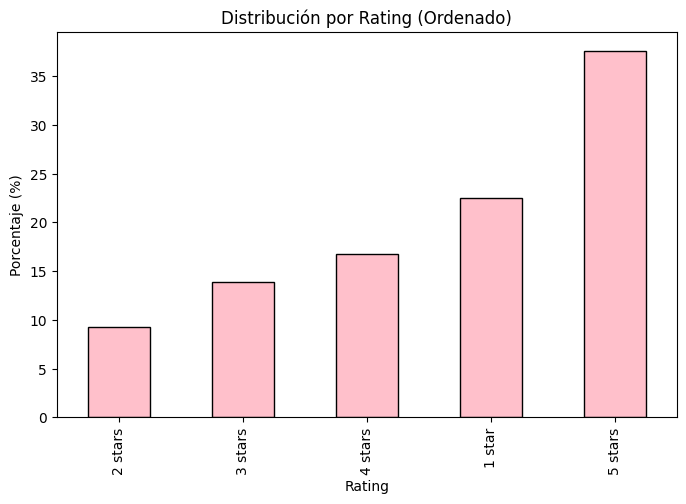

In [256]:

percent_val_sorted = percent_val.sort_values()

plt.figure(figsize=(8, 5))
percent_val_sorted.plot.bar(edgecolor='black', color='pink')
plt.title('Distribución por Rating (Ordenado)')
plt.xlabel('Rating')
plt.ylabel('Porcentaje (%)')
plt.show()


En el gráfico podemos ver la distribución de opiniones del mcdonald's ubicado en North Hollywood. La mayoria de la opiniones son de 5 estrellas, lo que indica una alta satisfacción en general, mientras que las claificaciones de 2 estrella son menos frecuentes. Sin embargo, destaca que las calificaciones de 1 estrella tienen un porcentaje considerablemente alto, superando a las de 2, 3 y 4 estrellas, lo que suigiere una división de las opiniones, con usarios muy satisfechos o muy insatisfechos, y menos opiniones intermedio.

In [257]:
# Analizamos las longitudes de las oraciones
import re
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    tokens = [lemmatizer.lemmatize(word.lower()) for word in text.split()
              if word.lower() not in stop_words]
    return ' '.join(tokens)

northollywood['cleaned_review'] = northollywood['review'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-257-97db29db5ee5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  northollywood['cleaned_review'] = northollywood['review'].apply(preprocess_text)


Text(0, 0.5, 'Frecuencia')

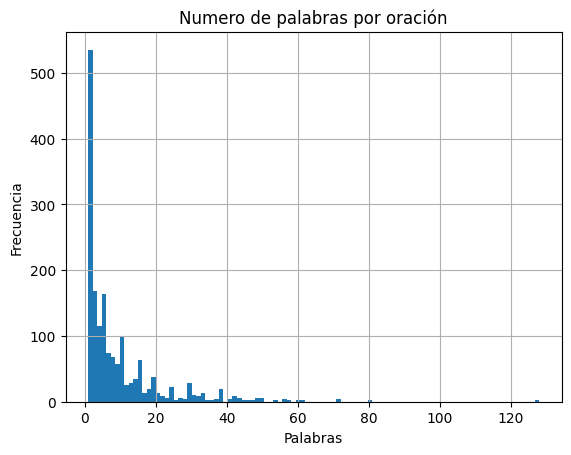

In [258]:
# Veemos el numero de palabras por oración
words_per_review = northollywood.cleaned_review.apply(lambda x: len(x.split(" ")))
words_per_review.hist(bins = 100)
plt.title('Numero de palabras por oración')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')

En el gráfico podemos ver la distribución de la cantidad de palabras por oración, donde la mayoría de las oraciones tienen menos de 20 de palabras, con un punto muy alto en las oraciones más cortas (menores a 10 palabras). Eso indica que el texto está compuesto principalmentepor oiraciones breves, lo que podria reflejar un estilo de comuncación directo y conciso. A medida que aumenta el número de palabras por oración, la frecuencia disminuye drásticamente, siendo muy pocas las oraciones que superan las 40 palabras.

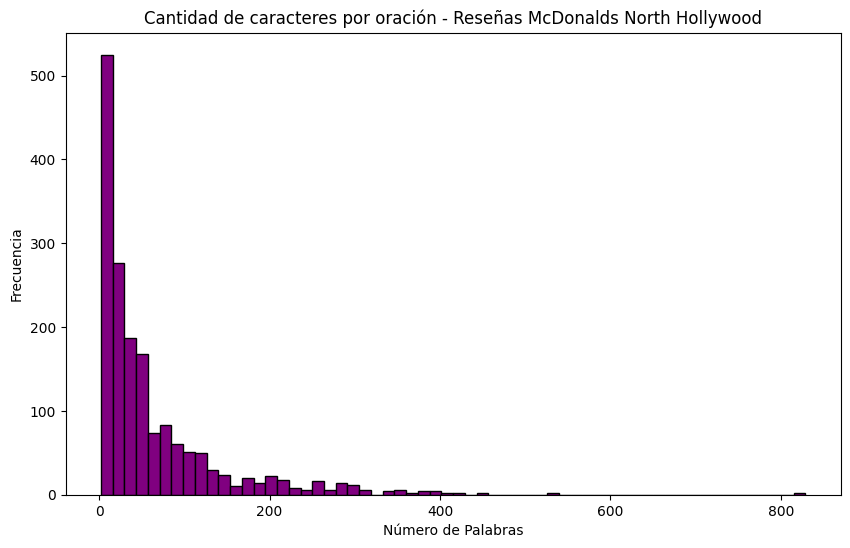

In [259]:


# Cantidad de caracteres por oración
sentence_lengths = [len(sentence) for sentence in northollywood['cleaned_review']]

plt.figure(figsize=(10, 6))
plt.hist(sentence_lengths, bins=60, edgecolor='black', color='purple')
plt.title('Cantidad de caracteres por oración - Reseñas McDonalds North Hollywood')
plt.xlabel('Número de Palabras')
plt.ylabel('Frecuencia')
plt.show()


Podemos observar la distribución de la cantidad de caracteres por oración en las reseñas. La mayoria de las oraciones tienen menos de 200 caracteres, con un punto alto muy destacable en las oraciones más cortas, similar a lo que se observa en el gráfico anterior.  A medida que aumenta el número de caracteres, la frecuencia disminuye rápidamente, siendo muy pocas las oraciones que superan los 400 caracteres. Esto sugiere que las reseñas están compuestas principalmente por frases concisas.

In [212]:
# Contamos las palabras en nuestro texto ya procesado
all_words = ' '.join(northollywood['cleaned_review']).split()
word_counts = Counter(all_words)

# Convertimos el conteo a un DataFrame para facilitar el análisis
word_counts_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency'])
word_counts_df = word_counts_df.sort_values(by='Frequency', ascending=False)

# Mostramos las 20 palabras más comunes
print(word_counts_df.head(20))

          Word  Frequency
74   mcdonalds        319
79        food        295
278    service        282
38       order        278
77        good        251
158      drive        222
435       fast        170
40        time        160
183       thru        148
114        get        144
22       place        141
112     always        140
276      great        136
136        fry        115
8          one        112
199   location        110
279  excellent        105
323   friendly         92
104         go         92
1         like         92


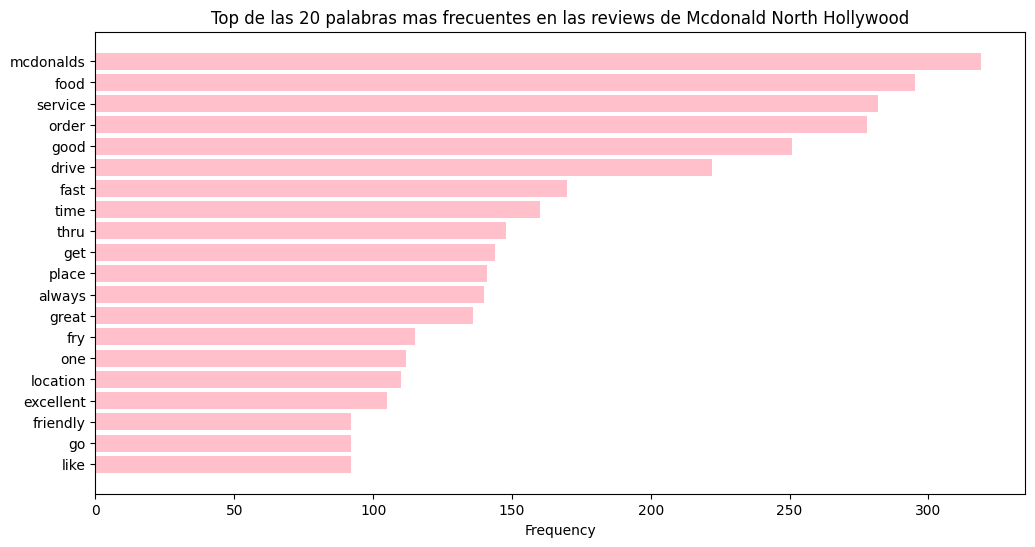

In [260]:
# Gráfico de barras de las 20 palabras más comunes
top_words = word_counts_df.head(20)

plt.figure(figsize=(12, 6))
plt.barh(top_words['Word'], top_words['Frequency'], color='pink')
plt.xlabel('Frequency')
plt.title('Top de las 20 palabras mas frecuentes en las reviews de Mcdonald North Hollywood')
plt.gca().invert_yaxis()  # Invertir el eje y para mostrar la palabra más frecuente en la parte superior
plt.show()

Antes de analizar el gráfico, nos damos cuenta que existe la presencia de la palabra Mcdonald que es la más repetida, por lo que optaremos por eliminarla para que no intervenga en el análisis.

          Word  Frequency
79        food        295
278    service        282
38       order        278
77        good        251
158      drive        222
435       fast        170
40        time        160
183       thru        148
114        get        144
22       place        141
112     always        140
276      great        136
136        fry        115
8          one        112
199   location        110
279  excellent        105
323   friendly         92
104         go         92
1         like         92
82     parking         89


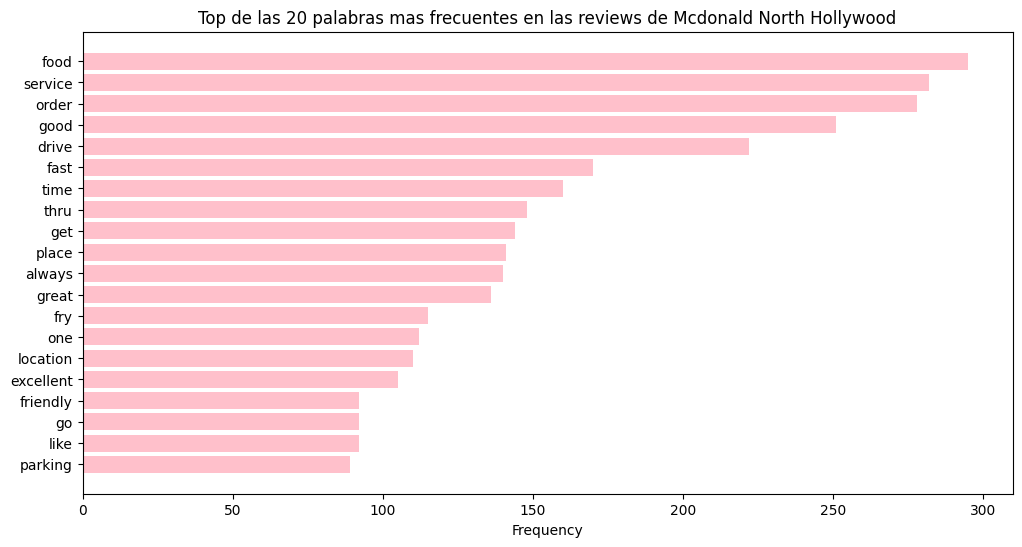

In [261]:
# Sacaremos Mcdonalds  del análisis por que  es una palabra que se repite mucho y no aporta al analisis.
# Realizamos nuevamente el grafico de frecuencias
stop_words_custom = {'mcdonalds'}

filtered_word_counts_df = word_counts_df[~word_counts_df['Word'].isin(stop_words_custom)]

print(filtered_word_counts_df.head(20))

top_filtered_words = filtered_word_counts_df.head(20)

plt.figure(figsize=(12, 6))
plt.barh(top_filtered_words['Word'], top_filtered_words['Frequency'], color='pink')
plt.xlabel('Frequency')
plt.title('Top de las 20 palabras mas frecuentes en las reviews de Mcdonald North Hollywood')
plt.gca().invert_yaxis()
plt.show()

Este gráfico nos muestra las 20 palabras más frecuentes en las reseñas de Mcdonalds North Hollywood, detacando palabras relacionadas con la experencia de las personas. Las palabras más comunes incluyen mcdonadls, food, service, order y good, lo que sugiere que los aspectos más comentados estan relacionados con la comida, el servicio y los pedidos. Palabras como drive, fast, y thru nos indican que las personas tambien mencionan con frecuencia el servicio de autoservicio. Además, podermos visualizar que palabras como great, excellent y friendly reflejan comentarios positivos, mientras que time y get porian estar asociados a la experiencia de la espera o la rapidez del servicio. En general, podemos deducir que estas palabras revelan que los usuarios se enfocan principalmente en la calidad de la comida, la eficiencia del servicio y la experencia con el local.

Las 10 partes del discurso más comunes: [('NOUN', 4845), ('PROPN', 4650), ('SPACE', 2149), ('CCONJ', 1315), ('PRON', 768), ('DET', 741), ('X', 686), ('VERB', 500), ('ADP', 173), ('NUM', 133)]


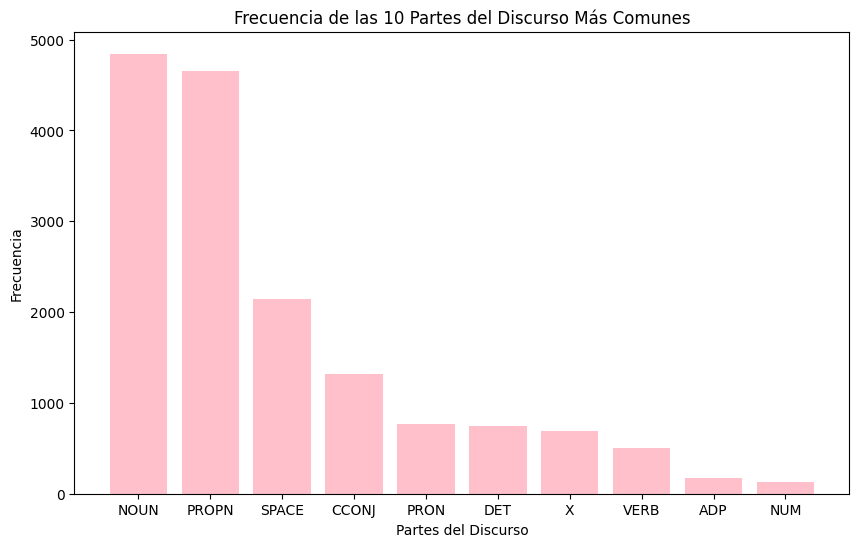

In [215]:
# Analizamos partes de los comentarios del review
nlp = spacy.load('en_core_web_sm')
# Función para obtener las partes del discurso (POS)def pos_tagging(sentence):
    doc = nlp(" ".join(sentence))
    return [(token.text, token.pos_) for token in doc]

# Aplicamos POS tagging (sólo con 100 reviews porque sino tarda mucho en ejecutar)
pos_tagged_corpus = [pos_tagging(sentence) for sentence in northollywood['cleaned_review'][:100]]

pos_counts = Counter([pos for sentence in pos_tagged_corpus for _, pos in sentence])

most_common_pos = pos_counts.most_common(10)
print("Las 10 partes del discurso más comunes:", most_common_pos)

pos, counts = zip(*most_common_pos)
plt.figure(figsize=(10, 6))
plt.bar(pos, counts, color='pink')
plt.title('Frecuencia de las 10 Partes del Discurso Más Comunes')
plt.xlabel('Partes del Discurso')
plt.ylabel('Frecuencia')
plt.show()


Este gráfico muestra la frecuencia de las 10 partes del discurso más comunes en un conjunto de texto. Los sustantivos (NOUN) y los nombres propios (PROPN) son las categorías más frecuentes, lo que indica que el texto está centrado en describir objetos, lugares, personas o conceptos específicos. La alta frecuencia de espacios (SPACE) sugiere que el texto tiene una estructura bien definida con oraciones separadas.

Número de palabras únicas en el corpus: 3446


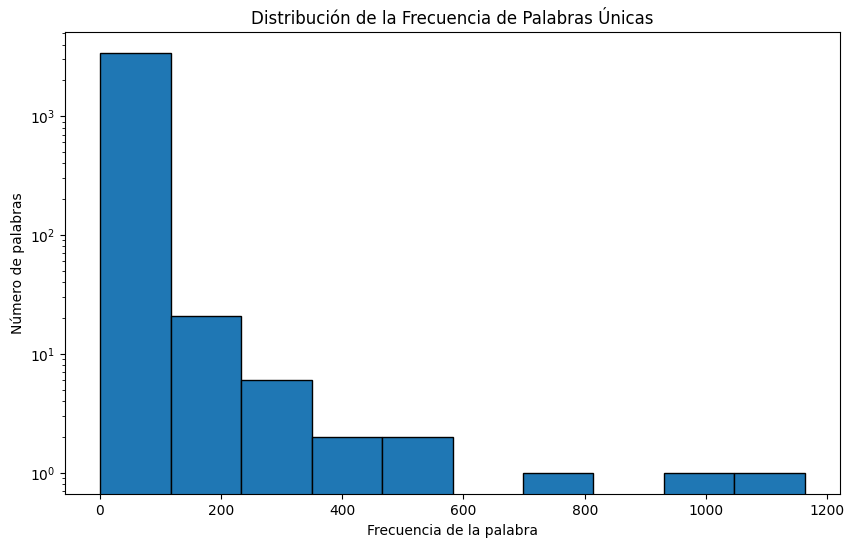

In [262]:
# Veamos la distribución de la Frecuencia de Palabras únicas

unique_words = set(all_words)
num_unique_words = len(unique_words)
print(f"Número de palabras únicas en el corpus: {num_unique_words}")
word_freq = Counter(all_words)

unique_word_freq = [word_freq[word] for word in unique_words]

plt.figure(figsize=(10, 6))
plt.hist(unique_word_freq, bins=10, edgecolor='black')
plt.title('Distribución de la Frecuencia de Palabras Únicas')
plt.xlabel('Frecuencia de la palabra')
plt.ylabel('Número de palabras')
plt.yscale('log')
plt.show()

Se puede observar  cómo se distribuyen las palabras únicas. La mayoría de las palabras aparecen con muy baja frecuencia, lo que es típico en textos donde muchas palabras son específicas o poco repetidas. Sin embargo, hay un pequeño grupo de palabras que se repiten con mucha frecuencia, lo que probablemente corresponde a términos comunes o relevantes en el contexto de las reseñas de McDonald's. Esto refleja una estructura lingüística donde unas pocas palabras dominan el texto, mientras que la mayoría son más variadas y específicas.

In [263]:
# Analizamos  N-grammas

vectorizer = CountVectorizer(ngram_range=(2,2))

X = vectorizer.fit_transform(northollywood['cleaned_review'])


n_grams = vectorizer.get_feature_names_out()

frequencies = X.toarray().sum(axis=0)


n_grams_freq = dict(zip(n_grams, frequencies))


df_n_grams = pd.DataFrame(n_grams_freq.items(), columns=['n_gram', 'frecuencia'])


df_n_grams = df_n_grams.sort_values(by='frecuencia', ascending=False).reset_index(drop=True)

df_n_grams.head(10)

,n_gram,frecuencia
0,drive thru,140
1,parking lot,54
2,fast food,40
3,customer service,40
4,fast service,34
5,good service,32
6,great service,26
7,order wrong,24
8,ice cream,22
9,big mac,21


In [219]:
# Veamos la diversidad Léxica
num_words = sum(len(sentence) for sentence in northollywood['cleaned_review'])
print(f"Número total de palabras en el corpus: {num_words}")

# Diversidad léxica
lexical_diversity = num_unique_words / num_words
print(f"Diversidad léxica: {lexical_diversity:.4f}")

Número total de palabras en el corpus: 108152
Diversidad léxica: 0.0187


Podemos ver que el corpus contiene un total de 108,152 palabras, pero con una diversidad léxica de 0.0187, lo que significa que hay una baja proporción de palabras únicas en relación con el total de palabras. Esto indica que el texto tiene un vocabulario repetitivo, probablemente debido a la naturaleza de las reseñas, donde los usuarios tienden a usar términos similares para describir sus experiencias (como "food", "service", "drive thru", etc.). Este patrón es común en textos temáticos o específicos, como reseñas de McDonald's, donde ciertos conceptos y palabras clave se repiten con frecuencia.

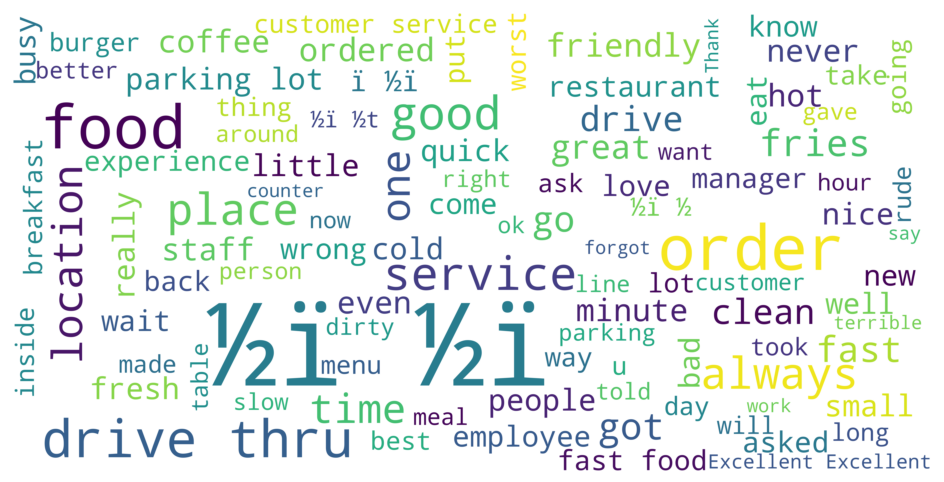

In [220]:
# Combinamos las reseñas en un solo texto
word_cloud_text = ''.join(northollywood.review)

# Definimos las palabras a excluir
custom_stopwords = {'mcdonalds', 'mcdonald'}

# Combinamos estas con las stopwords predefinidas
stopwords = STOPWORDS.union(custom_stopwords)

# Generamos la nube de palabras
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="white",
    scale=10,
    width=800,
    height=400,
    stopwords=stopwords  # Agregamos aca el conjunto de stopwords
).generate(word_cloud_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

La nube de palabras muestra los términos más frecuentes en las reseñas de McDonald's. Las palabras más destacadas, como "food", "service", "order", "drive thru", y "location", reflejan los temas principales que los clientes mencionan en sus opiniones. Términos positivos como "good", "friendly", y "great" sugieren experiencias satisfactorias, mientras que palabras como "wrong", "cold", y "dirty" indican críticas o problemas específicos. Además, conceptos como "time", "fast", y "employee" resaltan la importancia de la rapidez y la atención al cliente en las reseñas.

# Pre Procesamiento del texto

In [264]:
# crearemos una columna sentiment, en la que se reflejara el sentimiento del usuario a traves de las estrellas
# estrellas de 1, 2 y 3 son negativo, estrellas de 4 y 5 positivo.
def sentiment_label(rating):
    if '1 star' in rating or '2 stars' in rating or '3 stars' in rating:
        return 'negative'
    else:
        return 'positive'

northollywood['sentiment'] = northollywood['rating'].apply(sentiment_label)

<ipython-input-264-e28d1a81b2e5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  northollywood['sentiment'] = northollywood['rating'].apply(sentiment_label)


In [266]:
northollywood['sentiment'].value_counts()

,count
sentiment,
positive,930
negative,780


In [222]:
# Veamos todas las palabras más frecuentes de las review, para visualizar las palabras ruido
all_words = ' '.join(northollywood['review']).split()

word_counts = Counter(all_words)

print(word_counts.most_common(20))

[('the', 1163), ('and', 940), ('to', 699), ('a', 558), ('I', 545), ('is', 464), ('was', 412), ('in', 333), ('for', 302), ('of', 291), ('they', 269), ('The', 248), ('it', 244), ('but', 216), ('my', 207), ('this', 200), ('food', 197), ('drive', 196), ("McDonald's", 195), ('service', 180)]


In [223]:
# Vaamos a realizar la limpieza del texto, eliminando minusculas, caracteres no deseados, palabras ruidosas
# Tokenizaremos el texto en palabras.
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


custom_stopwords = {'the', 'and', 'to', 'a', 'is', 'was', 'in', 'for', 'of', 'it', 'but', 'my', 'this', 'they', 'food', 'drive', "McDonald's", 'service', 'thru'}

def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    tokens = text.lower().split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word not in custom_stopwords]
    cleaned_text = ' '.join(tokens)
    return cleaned_text


northollywood['cleaned_review'] = northollywood['review'].apply(preprocess_text)

print(northollywood[['review', 'cleaned_review']].head())

                                                  review                                     cleaned_review
16270  Looks like chicken nuggets bite piece served, ...  look like chicken nugget bite piece served cha...
16271  Raw Chicken Nuggets served here! If you want S...  raw chicken nugget served want salmonella plac...
16272  Avoid at all costs. Poorly designed driveway. ...  avoid cost poorly designed driveway employee m...
16273  Went in for a quick breakfast with family but ...  went quick breakfast family took longer expect...
16274  Very clean, and nice staff! A bonus: One of th...  clean nice staff bonus one people helping orde...


<ipython-input-223-211895d3434c>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  northollywood['cleaned_review'] = northollywood['review'].apply(preprocess_text)


In [224]:
from sklearn.feature_extraction.text import CountVectorizer
# Crearemos un vector de unigramas  y bigramas.
vectorizer = CountVectorizer(
    ngram_range=(1, 2), s
    tokenizer=lambda x: x.split()
)

X = vectorizer.fit_transform(northollywood['cleaned_review'])

print("Términos generados:", vectorizer.get_feature_names_out())

print("Matriz dispersa (X):", X)


Términos generados: ['aa' 'aa bit' 'able' ... 'ýýýý' 'ýýýý trash' 'ýýýý ýýýý']
Matriz dispersa (X):   (0, 3897)	1
  (0, 3690)	1
  (0, 1021)	2
  (0, 4789)	2
  (0, 642)	1
  (0, 5321)	1
  (0, 6191)	1
  (0, 964)	1
  (0, 4876)	1
  (0, 1251)	1
  (0, 1325)	1
  (0, 2856)	1
  (0, 6884)	1
  (0, 4646)	1
  (0, 2030)	1
  (0, 392)	1
  (0, 485)	1
  (0, 4633)	1
  (0, 5107)	1
  (0, 3901)	1
  (0, 3697)	1
  (0, 1026)	2
  (0, 4790)	1
  (0, 645)	1
  (0, 5323)	1
  :	:
  (1705, 1112)	1
  (1705, 5886)	1
  (1705, 7149)	1
  (1706, 786)	1
  (1706, 2084)	1
  (1706, 6855)	1
  (1706, 1281)	1
  (1706, 2093)	1
  (1706, 6856)	1
  (1706, 789)	1
  (1707, 7872)	1
  (1707, 4755)	1
  (1707, 1597)	1
  (1707, 4756)	1
  (1707, 1598)	1
  (1708, 627)	1
  (1708, 3580)	1
  (1708, 6498)	1
  (1708, 1587)	1
  (1708, 5552)	1
  (1708, 3581)	1
  (1708, 637)	1
  (1708, 6499)	1
  (1708, 1588)	1
  (1709, 5446)	1


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [225]:
# Ahora binarizamos la variable target sentiment en 0 (negativo) y 1 (positivo).
y = northollywood['sentiment'].map({'positive': 1, 'negative': 0})
y

,sentiment
16270,0
16271,0
16272,0
16273,0
16274,1
...,...
27339,0
27340,1
27341,0
27342,1


# Modelo Random Forest

Es importante mencionar que para este modelo no  se realizara estandarización, ya que el modelo no lo requiere.

In [269]:
# Importamos las librerias
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


In [268]:
# Dividimos el conjunto de entrenamiento y prueba.
# X e y fueron definidas previamente.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [229]:
# Definimos los hiperparametros del modelo.
hiperparametros = {
    "criterion": ["gini", "entropy"],
    "n_estimators": [20, 50, 100],
    "max_depth": [4, 5],
    "ccp_alpha": [0.01, 0.001, 0.005, 0.03]
}

busqueda = GridSearchCV(
    estimator = RandomForestClassifier(class_weight ="balanced",random_state =2024,n_jobs=-1),
    param_grid = hiperparametros,
    scoring = "f1",
    n_jobs = -1,
    cv = 5,
    verbose = 1
)

busqueda.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=2024),
             n_jobs=-1,
             param_grid={'ccp_alpha': [0.01, 0.001, 0.005, 0.03],
                         'criterion': ['gini', 'entropy'], 'max_depth': [4, 5],
                         'n_estimators': [20, 50, 100]},
             scoring='f1', verbose=1)

In [230]:
randomf = busqueda.best_estimator_
randomf.fit(X_train, y_train)


RandomForestClassifier(ccp_alpha=0.001, class_weight='balanced', max_depth=5,
                       n_jobs=-1, random_state=2024)

In [231]:
# validacion set de testeo
y_test_pred = randomf.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.91      0.57      0.70       159
           1       0.72      0.95      0.82       183

    accuracy                           0.77       342
   macro avg       0.81      0.76      0.76       342
weighted avg       0.81      0.77      0.76       342



El modelo de Random Forest tiene una accuracy del 77% en el conjunto de testeo, con un mejor desempeño en la clase 1 (recall de 0.95 y F1-score de 0.82), lo que indica que identifica correctamente la mayoría de los casos positivos. Sin embargo, tiene dificultades con la clase 0, donde el recall es más bajo (0.57), lo que sugiere que no detecta correctamente muchos casos negativos. La precisión para la clase 0 es alta (0.91), lo que indica que cuando predice negativos, suele acertar. En general, el modelo tiene un buen balance entre precisión y recall.

In [270]:
# creamos la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_test_pred)
conf_matrix

array([[ 91,  68],
       [  9, 174]])

La matriz de confusión y las métricas asociadas muestran el desempeño del modelo de Random Forest en clasificar dos clases (0 y 1). De los 159 casos reales de la clase 0, el modelo clasificó correctamente 91 (verdaderos negativos) y se equivocó en 68 (falsos positivos). Para la clase 1, de los 183 casos reales, el modelo clasificó correctamente 174 (verdaderos positivos) y falló en 9 (falsos negativos).

# Modelo Random Forest TF-IDF y Trigramas

In [232]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Mejora del preprocesamiento con TF-IDF y trigramas
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3), stop_words='english')  # Unigramas, bigramas y trigramas
X_preprocesada = tfidf_vectorizer.fit_transform(northollywood['cleaned_review'])  # Generar la matriz TF-IDF

# Dividir en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train_prep, X_test_prep, y_train_prep, y_test_prep = train_test_split(X_preprocesada, y, test_size=0.2, random_state=42)

hiperparametros = {
    "criterion": ["gini", "entropy"],
    "n_estimators": [20, 50, 100],
    "max_depth": [4, 5],
    "ccp_alpha": [0.01, 0.001, 0.005, 0.03]
}

busqueda = GridSearchCV(
    estimator = RandomForestClassifier(class_weight ="balanced",random_state = 41, n_jobs=-1),
    param_grid = hiperparametros,
    scoring = "f1",
    n_jobs = -1,
    cv = 5,
    verbose = 1
)

busqueda.fit(X_train, y_train)



Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=41),
             n_jobs=-1,
             param_grid={'ccp_alpha': [0.01, 0.001, 0.005, 0.03],
                         'criterion': ['gini', 'entropy'], 'max_depth': [4, 5],
                         'n_estimators': [20, 50, 100]},
             scoring='f1', verbose=1)

In [233]:
rf = busqueda.best_estimator_
rf.fit(X_train_prep, y_train_prep)

RandomForestClassifier(ccp_alpha=0.001, class_weight='balanced',
                       criterion='entropy', max_depth=5, n_jobs=-1,
                       random_state=41)

In [234]:

print(classification_report(y_test_prep, y_pred_rf_prep))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94       159
           1       0.92      0.99      0.95       183

    accuracy                           0.95       342
   macro avg       0.95      0.94      0.95       342
weighted avg       0.95      0.95      0.95       342



El uso de TF-IDF y trígramas en el preprocesamiento mejoró significativamente el desempeño del modelo de Random Forest. En el primer modelo, sin estas mejoras, la accuracy era del 77%, con un desequilibrio notable entre las clases: la clase 0 tenía un recall bajo (57%), lo que indicaba que muchos casos reales de esta clase no eran detectados correctamente. Además, el F1-score promedio era de 0.76, reflejando un desempeño moderado.

Con el preprocesamiento mejorado, el modelo alcanzó una accuracy del 95%, con un balance mucho mejor entre las clases. La clase 0 ahora tiene un recall del 90% y un F1-score de 0.94, mientras que la clase 1 tiene un recall del 99% y un F1-score de 0.95. Esto indica que el modelo no solo identifica correctamente la mayoría de los casos de ambas clases, sino que también reduce significativamente los errores de clasificación.


In [274]:
# creamos la matriz de confusión
conf_matrix = confusion_matrix(y_test_prep,  y_pred_rf_prep)
conf_matrix

array([[143,  16],
       [  2, 181]])

# Red Neuronal

In [238]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Supongamos que tienes un DataFrame llamado `northhollywood` con las columnas 'review' y 'label'

# Tokenización del texto
tokenizer = Tokenizer(num_words=10000)  # Consideramos las 10,000 palabras más frecuentes
tokenizer.fit_on_texts(northollywood['cleaned_review'])

# Convertir texto a secuencias
X1 = tokenizer.texts_to_sequences(northollywood['cleaned_review'])

# Padding para que todas las secuencias tengan la misma longitud
X1 = pad_sequences(X1, maxlen=100)  # Rellenar o truncar a una longitud máxima de 100 palabras

# Codificar las etiquetas
label_encoder = LabelEncoder()
y1 = label_encoder.fit_transform(northollywood['sentiment'])  # Por ejemplo: "positivo" -> 1, "negativo" -> 0

# Dividir los datos en entrenamiento y prueba
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [240]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout

# Crear el modelo
model = Sequential()

# Capa de embedding: convierte palabras en vectores densos
model.add(Embedding(input_dim=10000, output_dim=128, input_length=100))

# Capa LSTM: captura relaciones contextuales en el texto
model.add(LSTM(64, return_sequences=False))

# Capa de Dropout: reduce el sobreajuste
model.add(Dropout(0.5))

# Capa densa: completamente conectada
model.add(Dense(64, activation='relu'))

# Capa de salida: activación sigmoid para clasificación binaria
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(
    X1_train, y1_train,
    epochs=10,  # Número de épocas
    batch_size=32,  # Tamaño del lote
    validation_split=0.2,  # Usar el 20% de los datos de entrenamiento para validación
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.5883 - loss: 0.6819 - val_accuracy: 0.6314 - val_loss: 0.6347
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.7002 - loss: 0.5909 - val_accuracy: 0.7737 - val_loss: 0.5057
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.8730 - loss: 0.3412 - val_accuracy: 0.8358 - val_loss: 0.4032
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.9323 - loss: 0.1911 - val_accuracy: 0.8358 - val_loss: 0.3653
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.9545 - loss: 0.1348 - val_accuracy: 0.8577 - val_loss: 0.3931
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9733 - loss: 0.0678 - val_accuracy: 0.8577 - val_loss: 0.4555
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.9801 - loss: 0.0519 - val_accuracy: 0.8613 - val_loss: 0.4621
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.9840 - loss: 0.0649 - val_accuracy: 0.8467 -

In [242]:
# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X1_test, y1_test, verbose=1)
print(f"Exactitud en el conjunto de prueba: {accuracy:.2f}")

# Predecir etiquetas
y1_pred = (model.predict(X1_test) > 0.5).astype("int32")

# Reporte de clasificación
from sklearn.metrics import classification_report
print(classification_report(y1_test, y1_pred, target_names=label_encoder.classes_))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8932 - loss: 0.3129
Exactitud en el conjunto de prueba: 0.90
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
              precision    recall  f1-score   support

    negative       0.91      0.87      0.89       159
    positive       0.89      0.92      0.91       183

    accuracy                           0.90       342
   macro avg       0.90      0.90      0.90       342
weighted avg       0.90      0.90      0.90       342



La red neuronal tiene un buen desempeño, con un accuracy del 90% y métricas balanceadas entre las clases. La clase "negative" tiene una precisión del 91%, mientras que la clase "positive" destaca en recall con un 92%. El F1-score es alto para ambas clases (0.89 y 0.91), lo que refleja un buen equilibrio entre precisión y recall. Además, las métricas globales muestran que el modelo no está sesgado y maneja bien el desbalance de datos. En general, estoy satisfecho con cómo clasifica las reviews.

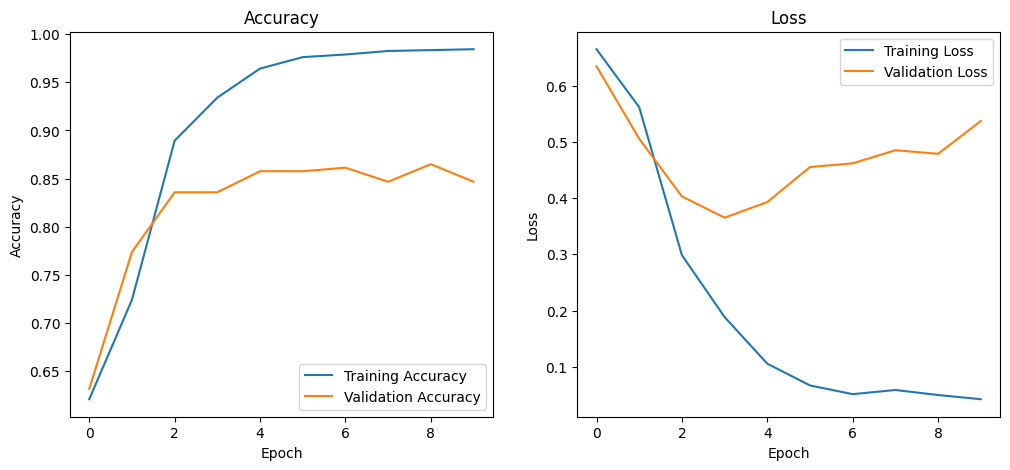

In [273]:

# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # Adjust figsize as needed

# Plot accuracy on the left subplot (ax1)
# Access history data through the 'history' attribute
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')

# Plot loss on the right subplot (ax2)
# Access history data through the 'history' attribute
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')

# Display the plot
plt.show()  # Add plt.show() to display the plot

El modelo muestra un buen aprendizaje inicial, con un accuracy de entrenamiento que alcanza casi el 100% y una pérdida que disminuye constantemente. Sin embargo, accuracy de validación se estabiliza alrededor del 85%-90% después de unas pocas épocas, mientras que la pérdida de validación comienza a aumentar ligeramente, lo que indica un posible sobreajuste. Esto sugiere que el modelo está memorizando los datos de entrenamiento en lugar de generalizar bien a los datos nuevos.

# Conclusiones

1. Distribución de Reseñas y Sentimientos:
* La mayoría de las reseñas son positivas, con una alta proporción de calificaciones de 5 estrellas. Sin embargo, las reseñas negativas (1 estrella) también representan una parte significativa, lo que indica polarización en las opiniones de los clientes.
* Las reseñas negativas suelen estar asociadas con problemas recurrentes como tiempos de espera, errores en los pedidos y limpieza, mientras que las positivas destacan la rapidez del servicio y la amabilidad del personal.
2. Análisis de Texto:
* Las palabras más frecuentes en las reseñas incluyen términos como "food", "service", "order", "drive-thru" y "location", lo que refleja los temas principales mencionados por los clientes.
* Los n-gramas más comunes, como "drive-thru", "parking lot" y "fast service", destacan aspectos clave de la experiencia del cliente, tanto positivos como negativos.
* La diversidad léxica del corpus es baja (0.0187), lo que sugiere que los clientes tienden a usar un vocabulario limitado y repetitivo en sus reseñas.
3. Modelo de Clasificación:-
* `Modelo Random Forest`:
  * Este modelo tiene un desempeño moderado, pero su capacidad para identificar reseñas negativas es limitada, lo que podría llevar a una subestimación de los problemas reportados por los clientes.
* `Modelo Random Forest (Con TF-IDF y Trigramas)`
  * Este modelo es altamente efectivo y balanceado, logrando identificar tanto reseñas positivas como negativas con gran precisión. Es una solución robusta para el análisis de sentimientos.
* `Modelo de Red Neuronal (LSTM)`:
  * Aunque el modelo de red neuronal tiene un desempeño ligeramente inferior al modelo Random Forest con TF-IDF, sigue siendo una opción viable,
  especialmente para capturar relaciones contextuales en el texto.

* El modelo Random Forest con TF-IDF y trigramas es el más adecuado para el objetivo del proyecto, ya que ofrece el mejor equilibrio entre precisión y recall para ambas clases, con un desempeño general sobresaliente.
* La red neuronal es una alternativa sólida, pero su desempeño es ligeramente inferior al modelo Random Forest mejorado.
* El modelo Random Forest sin preprocesamiento avanzado es menos efectivo y no se recomienda para este caso, ya que no logra identificar adecuadamente las reseñas negativas.